In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import time
import datetime
import os

from utils import raw_data_path,dump_pickle,load_pickle,cal_log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12, 8]
params = {
    'max_depth': 4,                 #4
#     'num_leaves': 80,
#    'min_data_in_leaf': 40,-
    'feature_fraction': 1,       #1
    'learning_rate': 0.04,          #0.04
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 2,
    'metric': 'binary_logloss',
}

if __name__ == '__main__':
    
    
    t0 = time.time()
    train_data = load_pickle(path='../data/train_final_onehot.pkl')    
    train_Y = train_data['is_trade']
    train_data.drop('is_trade', axis=1, inplace=True) 

    
    cv_data = load_pickle(path='../data/valid_final_onehot.pkl')
    cv_Y = cv_data['is_trade']
    cv_data.drop('is_trade', axis=1, inplace=True) 

    
    test_data = load_pickle(path='../data/test_final_onehot.pkl')
    test_Y = test_data['is_trade']
    test_data.drop('is_trade', axis=1, inplace=True) 

    print('train shap:',train_data.shape)
    print('cv shape', cv_data.shape)
    print('test shape', test_data.shape)
    
    
    test_file = 'round1_ijcai_18_test_a_20180301.txt'
    test = pd.read_table(raw_data_path + test_file,delim_whitespace=True)
    test_id = test.instance_id
    
    drop_cols = ['context_id', 'user_id', 'shop_id', 'item_id','item_brand_id', 'instance_id', 'item_property_list']

    train_data.drop(drop_cols,axis=1,inplace=True)
    cv_data.drop(drop_cols,axis=1,inplace=True)
    test_data.drop(drop_cols,axis=1,inplace=True)
    

    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    lgb_cv = lgb.Dataset(cv_data.values, cv_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=5000,     #迭代次数
                    valid_sets=[lgb_train, lgb_cv],        #训练时需要评估的列表
                    verbose_eval=20,       #
                    early_stopping_rounds=150)
    predict_train = gbm.predict(train_data.values)
    predict_cv = gbm.predict(cv_data.values)
    predict_test = gbm.predict(test_data.values)
    
#     feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)

    
    print('训练损失:',cal_log_loss(predict_train, train_Y))
    print('验证损失:',cal_log_loss(predict_cv, cv_Y))
    t1 = time.time()
    print('训练时间:',t1 - t0)
    
    #全量评测
    train_data = pd.concat([train_data, cv_data],axis=0)
    train_Y = np.append(train_Y, cv_Y)
    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=489,     #迭代次数
                    verbose_eval=True)
    predict_test = gbm.predict(test_data.values)
    print('训练损失:',cal_log_loss(gbm.predict(train_data.values), train_Y))
    submission = pd.DataFrame({'instance_id':test_id,'predicted_score':predict_test})
    print('预测正样本比例:',len(submission.loc[submission.predicted_score>=0.5])/len(submission))
    submission.to_csv(r'../result/lgb_{}.txt'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False, sep=' ',line_terminator='\r')
    

train shap: (420676, 283)
cv shape (57411, 283)
test shape (18371, 283)


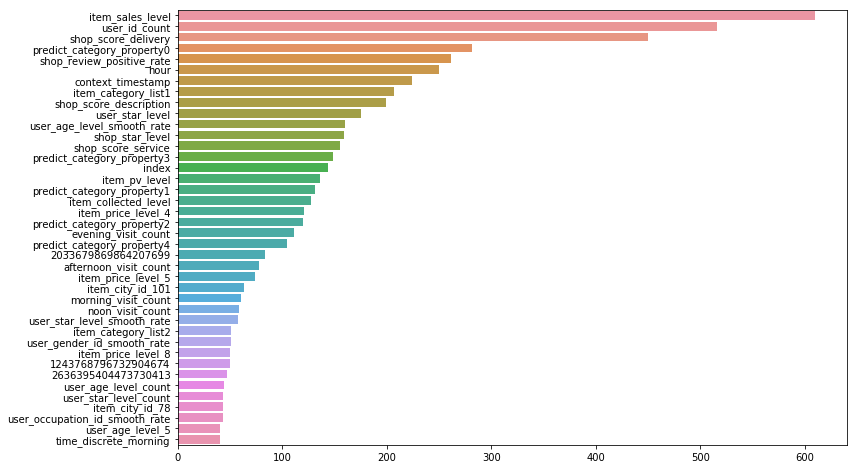

In [24]:
feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)[:40]
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.show()

In [18]:
(train_data==-1).sum(axis=0).sort_values(ascending=False)/train_data.shape[0]

user_id_lastday_count                       0.928944
time_diff_last_query                        0.489817
item_id_lastday_count                       0.307624
shop_id_lastday_count                       0.293547
num_trade_user_id_shop                      0.288033
num_user_id_shop                            0.288033
proportion_trade_user_id_shop               0.288033
num_trade_None_shop                         0.288033
num_None_shop                               0.288033
proportion_trade_None_shop                  0.288033
user_age_level_smooth_rate                  0.283781
user_occupation_id_smooth_rate              0.283781
user_star_level_smooth_rate                 0.283781
user_gender_id_smooth_rate                  0.283781
evening_visit_count                         0.131863
midnight_visit_count                        0.131863
morning_visit_count                         0.131863
noon_visit_count                            0.131863
afternoon_visit_count                       0.

In [6]:
test_data.user_id_count

478087   -1.0
478088   -1.0
478089   -1.0
478090   -1.0
478091   -1.0
478092   -1.0
478093   -1.0
478094   -1.0
478095   -1.0
478096   -1.0
478097   -1.0
478098   -1.0
478099   -1.0
478100   -1.0
478101   -1.0
478102   -1.0
478103   -1.0
478104   -1.0
478105   -1.0
478106   -1.0
478107   -1.0
478108   -1.0
478109   -1.0
478110   -1.0
478111   -1.0
478112   -1.0
478113   -1.0
478114   -1.0
478115   -1.0
478116   -1.0
         ... 
496428   -1.0
496429   -1.0
496430   -1.0
496431   -1.0
496432   -1.0
496433   -1.0
496434   -1.0
496435   -1.0
496436   -1.0
496437   -1.0
496438   -1.0
496439   -1.0
496440   -1.0
496441   -1.0
496442   -1.0
496443   -1.0
496444   -1.0
496445   -1.0
496446   -1.0
496447   -1.0
496448   -1.0
496449   -1.0
496450   -1.0
496451   -1.0
496452   -1.0
496453   -1.0
496454   -1.0
496455   -1.0
496456   -1.0
496457   -1.0
Name: user_id_count, Length: 18371, dtype: float64